In [60]:
# Necessary Imports
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [61]:
# Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [62]:
# Function to load and detect faces
def load_and_detect_faces(folder_path):
    images, labels = [], []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(
                        img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
                    )
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]
                        images.append(face_region)
                        labels.append(label)
    return images, labels


In [63]:
# Preprocess images with histogram equalization
def preprocess_images(images):
    preprocessed = [cv2.equalizeHist(cv2.resize(img, (64, 64))) for img in images]
    return preprocessed

In [64]:
# Data Augmentation
def augment_data(images, labels):
    augmented_images, augmented_labels = [], []
    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)
        # Augmentations: Flip
        augmented_images.append(cv2.flip(img, 1))  # Horizontal flip
        augmented_labels.append(label)
    return augmented_images, augmented_labels

In [65]:
# Feature Extraction with HOG
def extract_hog_features(images):
    features = []
    for img in images:
        hog_features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            transform_sqrt=True
        )
        features.append(hog_features)
    return np.array(features)


In [66]:
# Function to Train, Evaluate, and Return Metrics
def train_and_evaluate(train_path, test_path, dataset_name):
    print(f"Processing dataset: {dataset_name}")
    
    # Load and preprocess data
    X_train, y_train = load_and_detect_faces(train_path)
    X_test, y_test = load_and_detect_faces(test_path)
    X_train = preprocess_images(X_train)
    X_test = preprocess_images(X_test)
    X_train, y_train = augment_data(X_train, y_train)

    # Extract HOG features
    X_train_features = extract_hog_features(X_train)
    X_test_features = extract_hog_features(X_test)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_features_balanced, y_train_balanced = smote.fit_resample(X_train_features, y_train)

    # Train SVM with class weight balancing
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=7, gamma='scale', probability=True, class_weight='balanced'))
    
    # Perform Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(svm_model, X_train_features_balanced, y_train_balanced, cv=skf, scoring='accuracy')

    # Train the model
    svm_model.fit(X_train_features_balanced, y_train_balanced)

    # Evaluate on test set
    y_pred = svm_model.predict(X_test_features)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    classification_report_text = classification_report(y_test, y_pred, target_names=np.unique(y_test))

    # Visualize Confusion Matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f"Confusion Matrix: {dataset_name}")
    plt.show()

    # Plot Cross-Validation Scores
    plt.figure(figsize=(10, 5))
    plt.plot(cv_scores, marker='o', label='Validation Accuracy')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.title(f"Cross-Validation Accuracy per Fold: {dataset_name}")
    plt.legend()
    plt.show()

    # Return results
    print(f"Accuracy for {dataset_name}: {accuracy * 100:.2f}%")
    print(f"Classification Report for {dataset_name}:{classification_report_text}")
    return accuracy, classification_report_text, svm_model

In [67]:
def show_predictions_from_folder(images, predictions, filenames, n=3):
    plt.figure(figsize=(15, 5))
    for i in range(min(n, len(images))):
        img = images[i]
        pred_label = predictions[i]
        filename = filenames[i]
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.title(f'File: {filename}\nPred: {pred_label}')
        plt.axis('off')
    plt.show()

In [68]:
def load_test_images(folder_path, n=3):
    test_images = []  # Preprocessed images for testing
    original_images = []  # Original images to display
    filenames = []
    count = 0
    for img_file in sorted(os.listdir(folder_path)):  # Sort to process images in order
        if count >= n:  # Stop after loading `n` images
            break
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        original_img = cv2.imread(img_path)  # Load original image in color for display
        if img is not None:
            faces = face_cascade.detectMultiScale(
                img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)
            )
            if len(faces) > 0:  # If faces are detected
                # Select the face with the largest area (most prominent face)
                (x, y, w, h) = max(faces, key=lambda rect: rect[2] * rect[3])
                face_region = img[y:y+h, x:x+w]
                face_region = cv2.equalizeHist(cv2.resize(face_region, (64, 64)))
                test_images.append(face_region)
                original_images.append(original_img)  # Store the original image
                filenames.append(img_file)
                count += 1  # Increment count only after adding an image
    return test_images, original_images, filenames


In [69]:
# Paths for both datasets
datasets = {
    "CK_dataset": ("CK_dataset/train", "CK_dataset/test"),
    "JAFFE": ("JAFFE-[70,30]/train", "JAFFE-[70,30]/test")
}

Processing dataset: CK_dataset


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

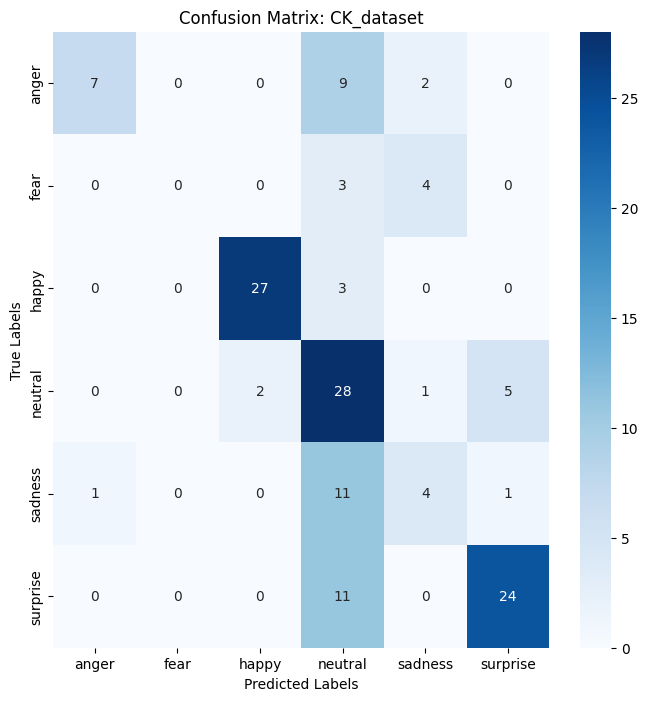

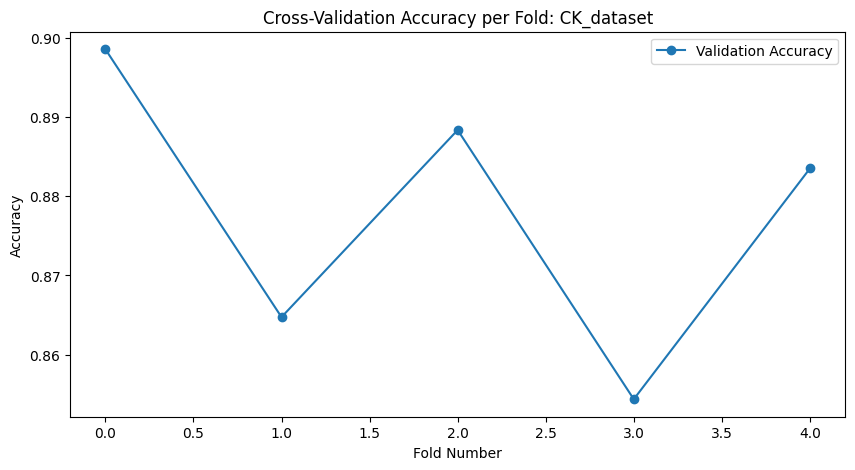

Accuracy for CK_dataset: 62.94%
Classification Report for CK_dataset:              precision    recall  f1-score   support

       anger       0.88      0.39      0.54        18
        fear       0.00      0.00      0.00         7
       happy       0.93      0.90      0.92        30
     neutral       0.43      0.78      0.55        36
     sadness       0.36      0.24      0.29        17
    surprise       0.80      0.69      0.74        35

    accuracy                           0.63       143
   macro avg       0.57      0.50      0.51       143
weighted avg       0.65      0.63      0.61       143

Processing dataset: JAFFE


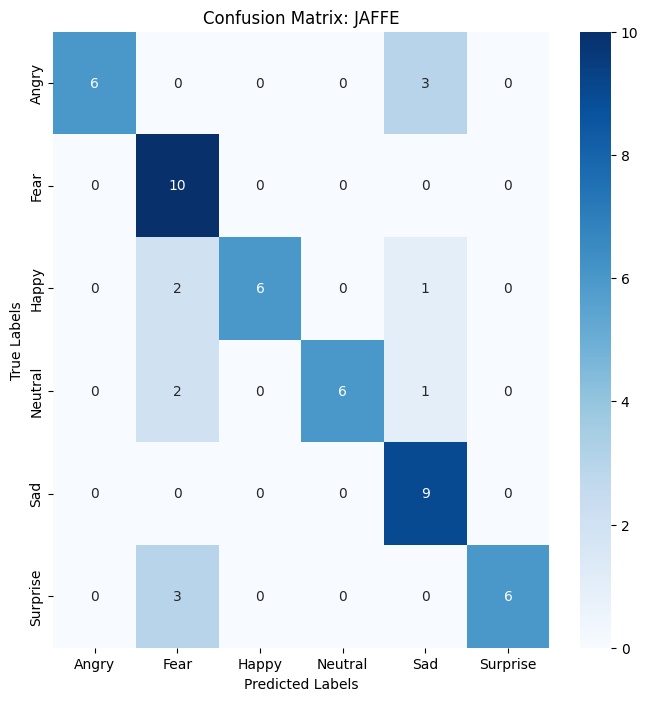

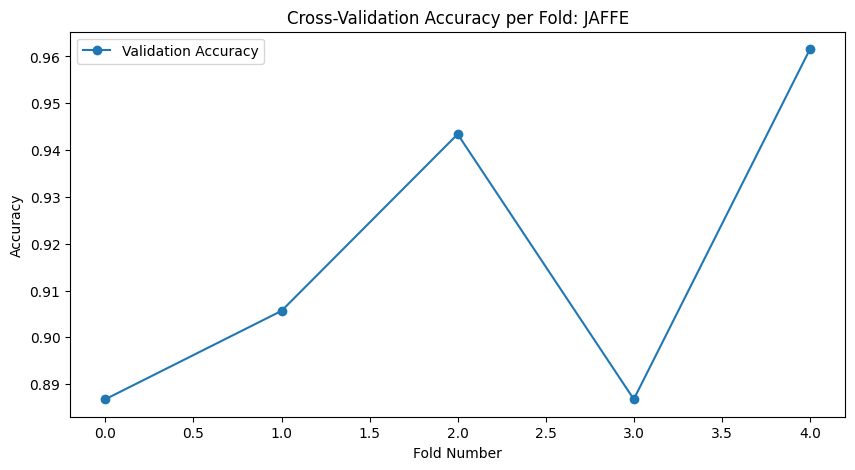

Accuracy for JAFFE: 78.18%
Classification Report for JAFFE:              precision    recall  f1-score   support

       Angry       1.00      0.67      0.80         9
        Fear       0.59      1.00      0.74        10
       Happy       1.00      0.67      0.80         9
     Neutral       1.00      0.67      0.80         9
         Sad       0.64      1.00      0.78         9
    Surprise       1.00      0.67      0.80         9

    accuracy                           0.78        55
   macro avg       0.87      0.78      0.79        55
weighted avg       0.87      0.78      0.79        55



In [70]:
# Evaluate on each dataset
results = {}
models = {}
for dataset_name, (train_path, test_path) in datasets.items():
    accuracy, report, model = train_and_evaluate(train_path, test_path, dataset_name)
    results[dataset_name] = {
        "Accuracy": accuracy,
        "Classification Report": report
    }
    models[dataset_name] = model

In [71]:
# Test with testimages Folder (Load only first 3 images)
test_images_path = "testimages"
test_images, original_images, test_filenames = load_test_images(test_images_path, n=3)

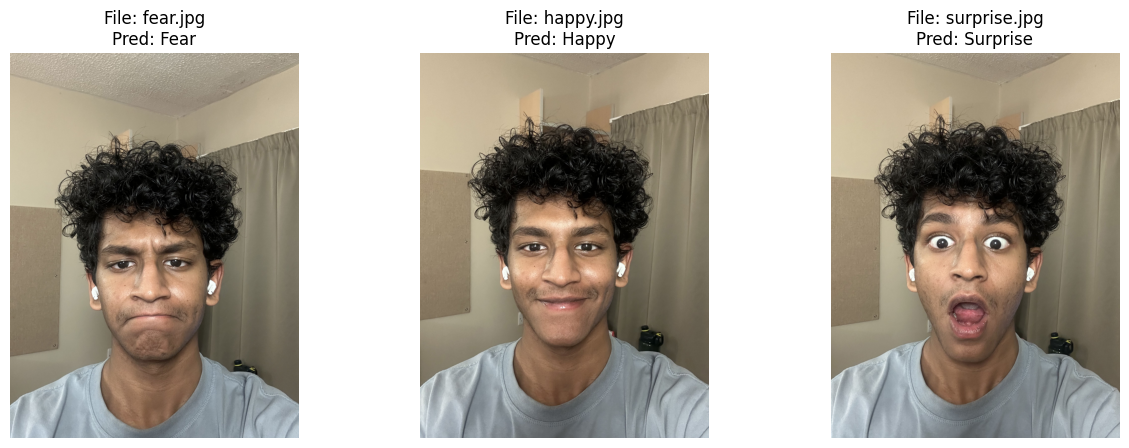

In [75]:
# Predict with the model trained on JAFFE
test_images_features = extract_hog_features(test_images)
jaffe_model = models["JAFFE"]  # Change from CK_dataset to JAFFE
test_predictions = jaffe_model.predict(test_images_features)
show_predictions_from_folder(original_images, test_predictions, test_filenames, n=3)

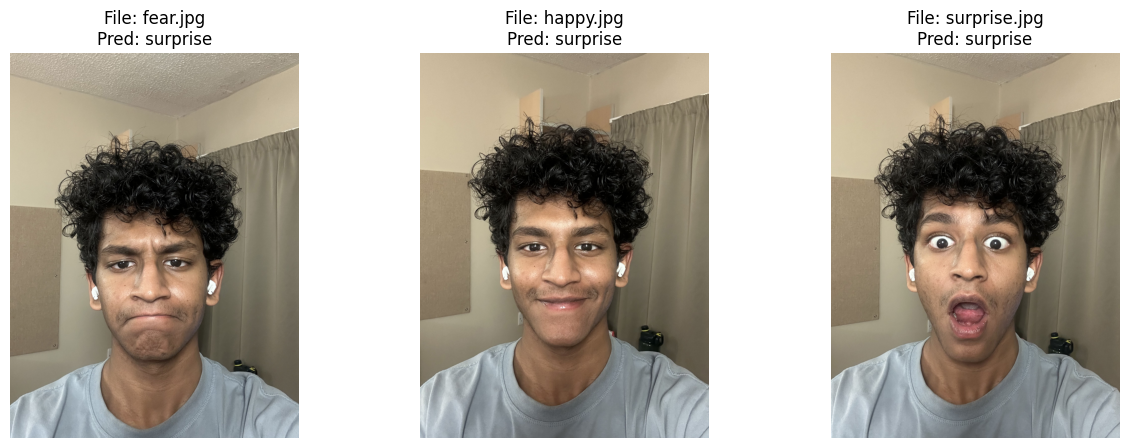

In [76]:
# Predict with the model trained on CK_dataset
test_images_features = extract_hog_features(test_images)
ck_model = models["CK_dataset"]
test_predictions = ck_model.predict(test_images_features)
show_predictions_from_folder(original_images, test_predictions, test_filenames, n=3)

In [74]:
# Compare Results
for dataset_name, metrics in results.items():
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {metrics['Accuracy'] * 100:.2f}%")
    print(f"Classification Report:\n{metrics['Classification Report']}")

Dataset: CK_dataset
Accuracy: 62.94%
Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.39      0.54        18
        fear       0.00      0.00      0.00         7
       happy       0.93      0.90      0.92        30
     neutral       0.43      0.78      0.55        36
     sadness       0.36      0.24      0.29        17
    surprise       0.80      0.69      0.74        35

    accuracy                           0.63       143
   macro avg       0.57      0.50      0.51       143
weighted avg       0.65      0.63      0.61       143

Dataset: JAFFE
Accuracy: 78.18%
Classification Report:
              precision    recall  f1-score   support

       Angry       1.00      0.67      0.80         9
        Fear       0.59      1.00      0.74        10
       Happy       1.00      0.67      0.80         9
     Neutral       1.00      0.67      0.80         9
         Sad       0.64      1.00      0.78         9
    Surprise     